# Data Merging & Data Transformation

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import natsort
import numpy as np
import os

from numpy.fft import fft
from mpl_toolkits.mplot3d import Axes3D

In [102]:
# 1, 2 통합 cell
def fft_spindle(data):
    # FFT
    N = len(data) # 10000 (1초간 10000개 data 측정)
    T = 1.0 / 10000 # 측정 주기
    amp_x_dis = fft(data['x_dis'].values) # fft 결과 x_dis 열의 amplitude 값
    amp_y_dis = fft(data['y_dis'].values) # fft 결과 y_dis 열의 amplitude 값
    amp_x_dis = 2.0/N * np.abs(amp_x_dis[:N//2]) # 반만 필요
    amp_y_dis = 2.0/N * np.abs(amp_y_dis[:N//2])
    freq = np.linspace(0.0, 1.0/(2.0*T), N//2) # frequency (반만 가져옴)
    return freq, amp_x_dis, amp_y_dis

def merge_and_transform(data_path_list, spindle_idx, threshold=0.001, fft_example_idx=0):
    #============================================================
    # data_path_list : TEST_160 등 데이터 들어간 폴더의 path들의 list
    # spindle_idx : 폴더 안에 SPINDLE1_TEST인지, SPINDLE2_TEST인지 등
    # threshold : 튄 값의 기준
    # fft_example_idx : fft 그려볼 index (default: 0)
    #============================================================
    transformed_dfs = []
    
    for directory in data_path_list:
        print('#########################################################')
        print("for the directory '{}'".format(directory))
        file_paths = []
        file_names = []
        for dirname, _, filenames in os.walk(directory):
            filenames = natsort.natsorted(filenames)
            for filename in filenames:
                path = os.path.join(dirname, filename)
                if (path.endswith('txt') and 'SPINDLE' + str(spindle_idx) + '_TEST' in path and '-' in path and 'RMS' not in path):
                    file_paths.append(path)
                    file_names.append(filename)
        print("Num of paths: ", len(file_paths))
    
        # 초당 데이터 FFT 변환
        t_data = []
        for i in range(len(file_paths)):
            t_data.append(pd.read_table(file_paths[i], sep='\t', header=None,
                                        names=['time', 'x_acc', 'time2', 'y_acc', 'time3', 'temperature',
                                               'time4', 'x_dis', 'time5', 'y_dis']))
            # 불필요한 열 삭제
            t_data[i].drop(['time2', 'time3', 'temperature', 'time4', 'time5'], axis=1, inplace=True)
        
        print("Num of time domain data: ", len(t_data))
        
        # 새로운 df 생성
        filteredFreq = []
        numPop_total = [] # x, y distance 총 튄 값 개수
        numPop_x = [] # x distance 튄 값 개수 list
        numPop_y = [] # y distance 튄 값 개수 list
        popVal_x = [] # x distance 튄 값들의 평균값 list
        popVal_y = [] # y distance 튄 값들의 평균값 list
        popVal_mean = [] # x, y 전체 튄 값들의 평균값 list
        
        # 20000 기준으로 나눠서 진행 (메모리 문제)
        num_data = len(t_data)
        k = num_data // 20000
        for i in range(k + 1):
            for j in range(20000 * i, 20000 * (i + 1)):
                if j >= num_data:
                    print("transformed the data!")
                    break
                elif j % 10000 == 0: print("{}th new data created!".format(j))
                else:
                    freq, pop_x, pop_y = fft_spindle(t_data[j])
                    pop_x[0] = 0 # 맨 처음 값은 FFT 특성 상 큰 값을 가지므로 무시
                    pop_y[0] = 0
                    freq = np.where(((pop_x > threshold) | (pop_y > threshold)), freq, 0)
                    # print(len(freq))
                    # print(np.count_nonzero(freq))
                    pop_x = np.where(pop_x > threshold, pop_x, 0) # 튄 값만 그대로 두고 나머지는 0
                    pop_y = np.where(pop_y > threshold, pop_y, 0)
                    # print(len(pop_x))
                    # print(np.count_nonzero(pop_x))

                    filteredFreq.append(freq[np.nonzero(freq)]) # 튄 값의 freq를 하나의 리스트로
                    numPop_total.append(np.count_nonzero(freq))
                    numPop_x.append(np.count_nonzero(pop_x))
                    numPop_y.append(np.count_nonzero(pop_y))
                    popVal_x.append(np.sum(pop_x) / np.count_nonzero(pop_x))
                    popVal_y.append(np.sum(pop_y) / np.count_nonzero(pop_y))
                    popVal_mean.append((np.sum(pop_x) + np.sum(pop_y)) /
                                       (np.count_nonzero(pop_x) + np.count_nonzero(pop_y)))
        df = pd.DataFrame({
            'Filtered_freq_list' : filteredFreq,
            'popCount_freq' : numPop_total,
            'popCount_x' : numPop_x,
            'popCount_y' : numPop_y,
            'popDegree_mean_x' : popVal_x,
            'popDegree_mean_y' : popVal_y,
            'popDegree_total_mean' : popVal_mean
        })
        print(df.info())
        
        transformed_dfs.append(df)
        print('#########################################################')
        print()
        
    print('num of transformed df: ', len(transformed_dfs))
    print()

    # 마지막 directory의 FFT Plot
    freq, amp_x, amp_y = fft_spindle(t_data[fft_example_idx])
    plt.plot(freq, amp_x)
    plt.xlim(0, 5000)
    plt.ylim(0, 0.001)
    plt.show()
    
    return transformed_dfs

In [87]:
!pwd

/Volumes/Spindle/Analysis_of_Spindle_Motor_Failure/K-meansClustering


In [110]:
path = ['/Volumes/Spindle/S2_MR1_U2/TEST_160(testtest)']
path[0].split('/')[4].split('(')[0]

'TEST_160'

#########################################################
for the directory '/Volumes/Spindle/S2_MR1_U2/TEST_165(가속도 x 중간에 멈춤)'
Num of paths:  11246
Num of time domain data:  11246
0th new data created!
10000th new data created!
transformed the data!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11244 entries, 0 to 11243
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Filtered_freq_list    11244 non-null  object 
 1   popCount_freq         11244 non-null  int64  
 2   popCount_x            11244 non-null  int64  
 3   popCount_y            11244 non-null  int64  
 4   popDegree_mean_x      11244 non-null  float64
 5   popDegree_mean_y      11244 non-null  float64
 6   popDegree_total_mean  11244 non-null  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 615.0+ KB
None
#########################################################
##########################################

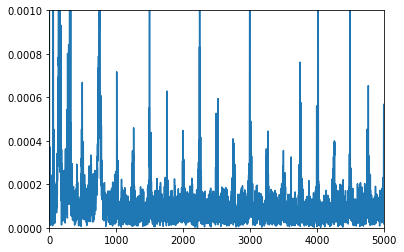

In [113]:
paths = ['/Volumes/Spindle/S2_MR1_U2/TEST_165(가속도 x 중간에 멈춤)', '/Volumes/Spindle/S2_MR1_U2/TEST_167(하중부가시험 영향으로 데이터가 많이 튐)', '/Volumes/Spindle/S2_MR1_U2/TEST_168',
        '/Volumes/Spindle/S2_MR1_U2/TEST_169', '/Volumes/Spindle/S2_MR1_U2/TEST_170', '/Volumes/Spindle/S2_MR1_U2/TEST_171',
        '/Volumes/Spindle/S2_MR1_U2/TEST_172', '/Volumes/Spindle/S2_MR1_U2/TEST_173', '/Volumes/Spindle/S2_MR1_U2/TEST_174',
        '/Volumes/Spindle/S2_MR1_U2/TEST_175', '/Volumes/Spindle/S2_MR1_U2/TEST_167(하중부가시험 영향으로 데이터가 많이 튐)']
dfs = merge_and_transform(paths, 1)

In [114]:
# dataframe as pickle file
save_paths = []
for i in range(len(dfs)):
    save_paths.append(paths[i].split('/')[4].split('(')[0]) # 괄호 제외, TEST_XXX
    with open('/Volumes/Spindle/S2_MR1_U2/PickleData/transformed_' + save_paths[i] + '.pickle', 'wb') as w:
        pickle.dump(dfs[i], w)

## Load transformed dataframe files and merge them

In [7]:
# load transformed dataframe files
dir_path = '/Volumes/Spindle/S2_MR1_U2/PickleData/'
data_paths = []

for dirname, _, filenames in os.walk(dir_path):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        if path.endswith('.pickle') and 'transformed' in filename and '.pickle' in filename:
            data_paths.append(path)

for i in range(5):
    print(data_paths[i])
print('transformed dataframe file 총 개수: ', len(data_paths))

/Volumes/Spindle/S2_MR1_U2/PickleData/transformed_TEST_160.pickle
/Volumes/Spindle/S2_MR1_U2/PickleData/transformed_TEST_163.pickle
/Volumes/Spindle/S2_MR1_U2/PickleData/transformed_TEST_165.pickle
/Volumes/Spindle/S2_MR1_U2/PickleData/transformed_TEST_166.pickle
/Volumes/Spindle/S2_MR1_U2/PickleData/transformed_TEST_167.pickle
transformed dataframe file 총 개수:  13


In [12]:
# merge them
df_list = []

for path in data_paths:
    with open(path, 'rb') as r:
        data = pickle.load(r)
    df_list.append(data)

df = pd.concat(df_list)
df.head()

,Filtered_freq_list,popCount_freq,popCount_x,popCount_y,popDegree_mean_x,popDegree_mean_y,popDegree_total_mean
0,"[296.0592118423685, 302.06041208241646, 305.06...",37,34,23,0.002791,0.002851,0.002815
1,"[296.0592118423685, 301.06021204240847, 302.06...",33,32,22,0.002903,0.002927,0.002913
2,"[296.0592118423685, 302.06041208241646, 304.06...",35,31,25,0.002958,0.002705,0.002845
3,"[296.0592118423685, 297.0594118823765, 302.060...",35,33,21,0.002736,0.002982,0.002832
4,"[274.05481096219245, 296.0592118423685, 301.06...",34,33,20,0.002734,0.003093,0.002869


In [15]:
df = df.astype({'popCount_freq' : 'float64'})
df = df.astype({'popCount_x' : 'float64'})
df = df.astype({'popCount_y' : 'float64'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36889 entries, 0 to 29
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Filtered_freq_list    36889 non-null  object 
 1   popCount_freq         36889 non-null  float64
 2   popCount_x            36889 non-null  float64
 3   popCount_y            36889 non-null  float64
 4   popDegree_mean_x      36889 non-null  float64
 5   popDegree_mean_y      36889 non-null  float64
 6   popDegree_total_mean  36889 non-null  float64
dtypes: float64(6), object(1)
memory usage: 2.3+ MB


In [17]:
# save to another path
with open('/Volumes/Spindle/S2_MR1_U2/df_for_clustering/transformed_and_merged.pickle', 'wb') as w:
    pickle.dump(df, w)

# load
with open('/Volumes/Spindle/S2_MR1_U2/df_for_clustering/transformed_and_merged.pickle', 'rb') as r:
    pickle.load(r)

## Plot

Text(0.5, 0.92, 'Visualization')

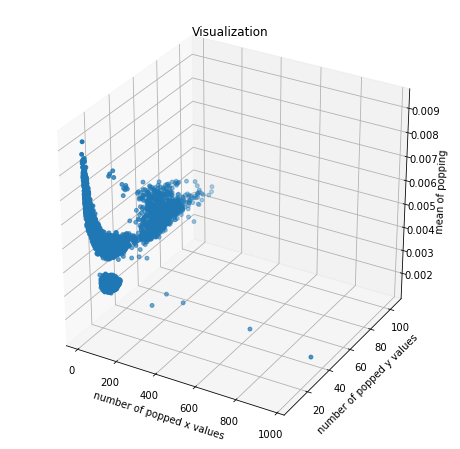

In [19]:
#3d scatter plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['popCount_x'], df['popCount_y'], df['popDegree_total_mean'], marker='o', s=15)
ax.set_xlabel('number of popped x values')
ax.set_ylabel('number of popped y values')
ax.set_zlabel('mean of popping')
plt.title('Visualization')

# K-means Clustering (k = 4)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36889 entries, 0 to 29
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Filtered_freq_list    36889 non-null  object 
 1   popCount_freq         36889 non-null  float64
 2   popCount_x            36889 non-null  float64
 3   popCount_y            36889 non-null  float64
 4   popDegree_mean_x      36889 non-null  float64
 5   popDegree_mean_y      36889 non-null  float64
 6   popDegree_total_mean  36889 non-null  float64
dtypes: float64(6), object(1)
memory usage: 2.3+ MB


In [22]:
# set null to 0
df.fillna(0, inplace=True)
# df.isnull()

In [23]:
from sklearn.cluster import KMeans

dataset = pd.DataFrame({"popCount_x" : df['popCount_x'],
                        "popCount_y" : df['popCount_y'],
                        "popDegree_mean_x" : df['popDegree_mean_x'],
                        "popDegree_mean_y" : df['popDegree_mean_y']})
kmeans = KMeans(n_clusters=4)
kmeans.fit(dataset)
kmeans_label = kmeans.labels_

print(kmeans.score(dataset))

print("k-means labels")
print(kmeans_label)
print()
print()

print("k-means cluster centers")
print(kmeans.cluster_centers_)
predictions = kmeans.fit_predict(dataset)

resDF = df.copy()
resDF["prediction"] = kmeans.labels_
resDF.head()

-1184780.4134922964
k-means labels
[0 0 0 ... 0 0 0]


k-means cluster centers
[[3.55764412e+01 2.40446879e+01 3.60893085e-03 3.86345445e-03]
 [2.79234750e+01 1.89467027e+01 3.59078085e-03 3.99265416e-03]
 [7.99000000e+02 3.85000000e+01 1.37412915e-03 3.90194629e-03]
 [5.80037915e+01 6.29459716e+01 4.03792379e-03 4.35389469e-03]]


,Filtered_freq_list,popCount_freq,popCount_x,popCount_y,popDegree_mean_x,popDegree_mean_y,popDegree_total_mean,prediction
0,"[296.0592118423685, 302.06041208241646, 305.06...",37.0,34.0,23.0,0.002791,0.002851,0.002815,0
1,"[296.0592118423685, 301.06021204240847, 302.06...",33.0,32.0,22.0,0.002903,0.002927,0.002913,0
2,"[296.0592118423685, 302.06041208241646, 304.06...",35.0,31.0,25.0,0.002958,0.002705,0.002845,0
3,"[296.0592118423685, 297.0594118823765, 302.060...",35.0,33.0,21.0,0.002736,0.002982,0.002832,0
4,"[274.05481096219245, 296.0592118423685, 301.06...",34.0,33.0,20.0,0.002734,0.003093,0.002869,0


## Clustering result plot

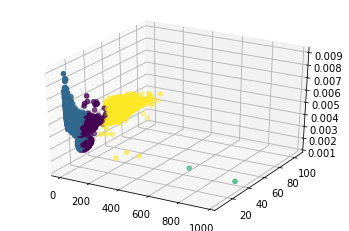

In [24]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.scatter(dataset['popCount_x'], dataset['popCount_y'], dataset['popDegree_mean_x'], c=kmeans_label)

# Analysis of Clustering

In [27]:
import random

## 1) Visualize the Frequency Distribution of each Clustered Data

### (1) Extract the data by each cluster and rand number

In [28]:
# cluster별 data 추출
cluster_0 = resDF[resDF.prediction == 0]
cluster_1 = resDF[resDF.prediction == 1]
cluster_2 = resDF[resDF.prediction == 2]

print(len(dataset))
print(len(cluster_0) + len(cluster_1) + len(cluster_2))
print(len(cluster_0), len(cluster_1), len(cluster_2))

36889
21208
20151 1055 2


In [29]:
random.seed(2021)
randInd_0 = random.randrange(0, len(cluster_0))
randInd_1 = random.randrange(0, len(cluster_1))
randInd_2 = random.randrange(0, len(cluster_2))

print(randInd_0)
print(randInd_1)
print(randInd_2)

13245
566
0


### (2) Cluster의 random point 별 Frequency 분포 확인

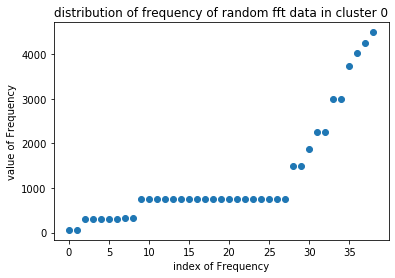

In [30]:
plt.plot(cluster_0.iloc[randInd_0]['Filtered_freq_list'], 'o')
plt.xlabel('index of Frequency')
plt.ylabel('value of Frequency')
plt.title('distribution of frequency of random fft data in cluster 0')
plt.show()

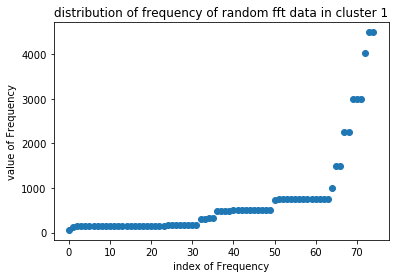

In [31]:
plt.plot(cluster_1.iloc[randInd_1]['Filtered_freq_list'], 'o')
plt.xlabel('index of Frequency')
plt.ylabel('value of Frequency')
plt.title('distribution of frequency of random fft data in cluster 1')
plt.show()

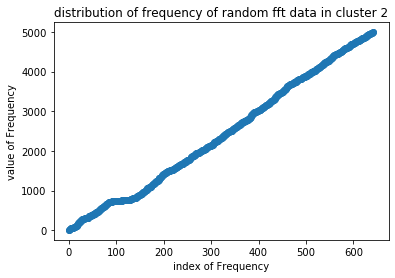

In [32]:
plt.plot(cluster_2.iloc[randInd_2]['Filtered_freq_list'], 'o')
plt.xlabel('index of Frequency')
plt.ylabel('value of Frequency')
plt.title('distribution of frequency of random fft data in cluster 2')
plt.show()

### (3) 다시 time domain에 cluster 색 별로 plot

In [33]:
len(resDF)

36889

36889
36889


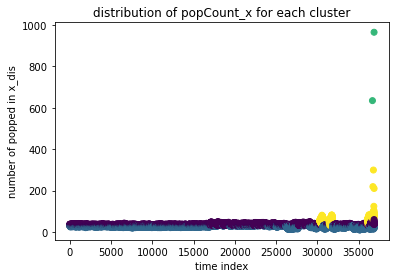

In [34]:
x = np.linspace(0,len(resDF), len(resDF))
print(len(x))
print(len(resDF['popCount_x']))
plt.scatter(x, resDF['popCount_x'], c=kmeans_label) #resDF['prediction'])
plt.xlabel('time index')
plt.ylabel('number of popped in x_dis')
plt.title('distribution of popCount_x for each cluster')
plt.show()

In [36]:
print(resDF.loc[resDF['prediction']])

                                   Filtered_freq_list  popCount_freq  \
0   [296.0592118423685, 302.06041208241646, 305.06...           37.0   
0   [294.05881176235243, 295.0590118023605, 296.05...           49.0   
0   [58.01160232046409, 301.06021204240847, 302.06...           47.0   
0   [294.05881176235243, 301.06021204240847, 306.0...           28.0   
0   [58.01160232046409, 59.01180236047209, 60.0120...           78.0   
..                                                ...            ...   
0   [58.01160232046409, 59.01180236047209, 305.061...           30.0   
0   [49.009801960392075, 58.01160232046409, 59.011...           29.0   
0   [60.01200240048009, 243.0486097219444, 306.061...           33.0   
0   [305.06101220244045, 306.06121224244845, 308.0...           29.0   
0   [58.01160232046409, 59.01180236047209, 302.060...           34.0   

    popCount_x  popCount_y  popDegree_mean_x  popDegree_mean_y  \
0         34.0        23.0          0.002791          0.002851   
0  